In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation
from sympy import Matrix, pi, pprint
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


class GasSimulation:
    def __init__(self, file_path):
        self.file_path = file_path
        self.chunk_size = 102609 // 9
        self.load_data()

    def load_data(self):
        self.accumulated_data = np.zeros((0, 12))
        for chunk in pd.read_csv(self.file_path, sep=' ', names=['x', 'y', 'z', 'vx', 'vy', 'vz', 'lxvel', 'lyvel', 'lzvel','Potential', 'U', 'rho'], header=None, chunksize=self.chunk_size):
            self.accumulated_data = np.concatenate([self.accumulated_data, chunk.values])
        print(len(self.accumulated_data[:, :3]))
        print('antes de',self.accumulated_data[:, :3])

    def calculate_center_of_mass_new(self):
        mass_i = 1e10
        N = len(self.accumulated_data)
        Log_energy = np.log10(self.accumulated_data[:, 10])
        avg_energy = np.mean(Log_energy)
        print('avr_energy',avg_energy)

        energy_filter = Log_energy < 2.78
        self.filtered_data = self.accumulated_data[energy_filter]
        print(len(self.filtered_data[:, :3]))
        print('--array',self.filtered_data[:, :3])
        center_of_mass_with_energy = np.sum(self.filtered_data[:, :3], axis=0) / N
        return center_of_mass_with_energy

    def calculate_total_angular_momentum(self):
        center_of_mass = self.calculate_center_of_mass_new()
        mass_i = 1e10
        N = len(self.filtered_data[:, 6])
        r_i = self.filtered_data[:, :3] - center_of_mass
        v_i = self.filtered_data[:, 3:6] - self.calculate_velocity_of_mass()
        total_angular_momentum = np.sum(np.cross(r_i, v_i), axis=0)
        return total_angular_momentum

    def calculate_velocity_of_mass(self):
        mass_i = 1e10
        N = len(self.filtered_data[:, 6])
        velocity_of_mass = np.sum(self.filtered_data[:, 3:6] * mass_i, axis=0) / (mass_i * N)
        return velocity_of_mass

    def choose_rotation_matrix(self, largest_component, direction):
        if largest_component == 0:
            if direction == 1:
                matrix = Rotation.from_euler('y', -pi/2).as_matrix()
            elif direction == -1:
                matrix = Rotation.from_euler('y', pi/2).as_matrix()
        elif largest_component == 1:
            if direction == 1:
                matrix = Rotation.from_euler('x', pi/2).as_matrix()
            elif direction == -1:
                matrix = Rotation.from_euler('x', -pi/2).as_matrix()
        elif largest_component == 2:
            if direction == 1:
                matrix = np.identity(3)
            elif direction == -1:
                matrix = Rotation.from_euler('z', pi).as_matrix()
        return matrix

    def apply_rotation(self, matrix, vector):
        rotated_array = np.zeros_like(vector)
        if vector.size == 3:
            rotated_array = np.dot(matrix, vector)
        else:
            for i in range(vector.shape[0]):
                rotated_array[i, :] = np.dot(matrix, vector[i, :])
        return rotated_array

    def visualize_rotated_vector(self):
        direction = angular_direction[largest_component]
        angle_rotation_matrix = self.choose_rotation_matrix(largest_component, direction)
        original_vector = self.calculate_total_angular_momentum()
        rotated_angular_momentum = self.apply_rotation(angle_rotation_matrix, original_vector)
        print('-'*80)
        print("Vector Original:", original_vector)
        print("Vector Rotado:", rotated_angular_momentum)
        print('-'*80)
        print(' '*80)

    def visualize_galaxy(self, original_vector, rotated_vector, title):

          # Crear una figura con dos subgráficos en una fila
          fig, axs = plt.subplots(1, 2, figsize=(10, 4))

          # Gráfico de la izquierda: Datos Rotados
          axs[0].scatter(rotated_vector[:, 0], rotated_vector[:, 1], color='blue', marker='o', s=0.003)
          axs[0].scatter(center_of_mass[0], center_of_mass[1], color='red', marker='x', s=5, label='CM')

          axs[0].set_title('Rotado')
          axs[0].set_xlim(-18, 18)
          axs[0].set_ylim(-18, 18)
          axs[0].set_xlabel('Eje X')
          axs[0].set_ylabel('Eje Y')
          axs[0].legend()

          # Gráfico de la derecha: Datos Sin Rotar
          axs[1].scatter(original_vector[:, 0], original_vector[:, 1], color='blue', marker='o', s=0.003)
          axs[1].scatter(center_of_mass[0], center_of_mass[1], color='red', marker='x', s=5, label='CM')

          axs[1].set_title('Sin Rotar')
          axs[1].set_xlim(-18, 18)
          axs[1].set_ylim(-18, 18)
          axs[1].set_xlabel('Eje X')
          axs[1].set_ylabel('Eje Y')
          axs[1].legend()

          # Ajustar el diseño para evitar superposiciones
          plt.tight_layout()

          # Mostrar los gráficos
          plt.suptitle(title)
          plt.show()
          plt.savefig(title)

    def visualize_galaxies(self, vectors, title, ax):
        ax.scatter(vectors[:, 0], vectors[:, 1], color='blue', marker='o', s=0.003 )
        ax.scatter(center_of_mass[0], center_of_mass[1], color='black', marker='x', s=7, label='Centro de masa')

        #ax.set_title(title)
        ax.set_xlim(-30, 30)
        ax.set_ylim(-30, 30)
        ax.annotate(title.split('.')[0] +' '+ title.split(' ')[1], xy=(0.5, 1), xycoords='axes fraction', ha='center', va='bottom')
        ax.legend()

    def visualize_3d_comparison(self, rotated_vector, title_rotated, original_vector, title_original):
        fig = plt.figure(figsize=(19, 10))

        # Gráfico de la izquierda: Datos Rotados en 3D
        ax1 = fig.add_subplot(221, projection='3d')
        ax1.scatter(rotated_vector[:, 0], rotated_vector[:, 1], rotated_vector[:, 2], color='blue', marker='o', s=0.003)
        ax1.scatter(center_of_mass[0], center_of_mass[1], center_of_mass[2], color='red', marker='+', s=50, label='CM')

        ax1.set_title(title_rotated + '(edge on)')
        ax1.set_xlim(-15, 15)
        ax1.set_ylim(-15, 15)
        ax1.set_zlim(-15, 15)
        ax1.view_init(elev=0, azim=110)  # Vista personalizada
        ax1.set_xlabel('Eje X')
        ax1.set_ylabel('Eje Y')
        ax1.set_zlabel('Eje Z')

        # Cambiar la posición de la caja que encierra el gráfico
        ax1.xaxis.pane.fill = False
        ax1.yaxis.pane.fill = False
        ax1.zaxis.pane.fill = False
        ax1.grid(alpha=0.3)

        # Gráfico de la izquierda: Datos Rotados en 3D
        ax3 = fig.add_subplot(223, projection='3d')
        ax3.scatter(rotated_vector[:, 0], rotated_vector[:, 1], rotated_vector[:, 2], color='blue', marker='o', s=0.003)
        ax3.scatter(center_of_mass[0], center_of_mass[1], center_of_mass[2], color='red', marker='+', s=50, label='CM')

        ax3.set_title(title_rotated + '(face on)')
        ax3.set_xlim(-15, 15)
        ax3.set_ylim(-15, 15)
        ax3.set_zlim(-15, 15)
        ax3.view_init(elev=84, azim=91)  # Vista personalizada
        ax3.set_xlabel('Eje X')
        ax3.set_ylabel('Eje Y')
        ax3.set_zlabel('Eje Z')

        # Cambiar la posición de la caja que encierra el gráfico
        ax3.xaxis.pane.fill = False
        ax3.yaxis.pane.fill = False
        ax3.zaxis.pane.fill = False
        ax3.grid(alpha=0.3)

        # Gráfico de la derecha: Datos Sin Rotar en 3D
        ax2 = fig.add_subplot(222, projection='3d')
        ax2.scatter(original_vector[:, 0], original_vector[:, 1], original_vector[:, 2], color='blue', marker='o', s=0.003)
        ax2.scatter(center_of_mass[0], center_of_mass[1], center_of_mass[2], color='red', marker='+', s=50, label='CM')

        ax2.set_title(title_original + '(edge on)')
        ax2.set_xlim(-15, 15)
        ax2.set_ylim(-15, 15)
        ax2.set_zlim(-15, 15)
        ax2.view_init(elev=0, azim=110)  # Vista personalizada
        ax2.set_xlabel('Eje X')
        ax2.set_ylabel('Eje Y')
        ax2.set_zlabel('Eje Z')

        # Cambiar la posición de la caja que encierra el gráfico
        ax2.xaxis.pane.fill = False
        ax2.yaxis.pane.fill = False
        ax2.zaxis.pane.fill = False
        ax2.grid(alpha=0.3)

        # Gráfico de la derecha: Datos Sin Rotar en 3D
        ax4 = fig.add_subplot(224, projection='3d')
        ax4.scatter(original_vector[:, 0], original_vector[:, 1], original_vector[:, 2], color='blue', marker='o', s=0.003)
        ax4.scatter(center_of_mass[0], center_of_mass[1], center_of_mass[2], color='red', marker='+', s=50, label='CM')

        ax4.set_title(title_original + '(face on)')
        ax4.set_xlim(-15, 15)
        ax4.set_ylim(-15, 15)
        ax4.set_zlim(-15, 15)
        ax4.view_init(elev=84, azim=91)  # Vista personalizada
        ax4.set_xlabel('Eje X')
        ax4.set_ylabel('Eje Y')
        ax4.set_zlabel('Eje Z')

        # Cambiar la posición de la caja que encierra el gráfico
        ax4.xaxis.pane.fill = False
        ax4.yaxis.pane.fill = False
        ax4.zaxis.pane.fill = False
        ax4.grid(alpha=0.3)

        plt.rcParams['grid.linewidth'] = 0.2  # change linwidth
        plt.rcParams['grid.color'] = "gray"  # change color
        plt.tight_layout()

        # Mostrar los gráficos
        plt.show()

In [ ]:
if __name__ == "__main__":

    halo_files = ['dhc_halo_11.gas', 'dhc_halo_17.gas'] #'halo_117256.gas', 'halo_119885.gas', 'halo_418336.gas']

    # Crear una figura con una matriz de subgráficos
    fig, axs = plt.subplots(5, 2, figsize=(12, 16), sharex=True, sharey=True)

    for i, file_name in enumerate(halo_files):

        simulation = GasSimulation(file_name)

        # Calcular los vectores originales y rotados
        center_of_mass = simulation.calculate_center_of_mass()
        total_angular_momentum = simulation.calculate_total_angular_momentum()
        angular_direction = np.sign(total_angular_momentum)
        largest_component = np.argmax(np.abs(total_angular_momentum))
        direction = angular_direction[largest_component]
        angle_rotation_matrix = simulation.choose_rotation_matrix(largest_component, direction)
        original_vectors = simulation.accumulated_data[:, :3]
        rotated_vectors = simulation.apply_rotation(angle_rotation_matrix, original_vectors)

        row = i
        col_1 = 0
        col_2 = 1
        simulation.visualize_galaxies(rotated_vectors, f'{file_name} (rotated)', axs[row, col_1])
        simulation.visualize_galaxies(original_vectors, f'{file_name} (original)', axs[row, col_2])



    # Ajustar el diseño para evitar superposiciones
    plt.tight_layout();
    plt.show();

24598
antes de [[-5.140900e-02 -2.615100e-02 -4.260000e-03]
 [-3.239200e-02 -1.310100e-02  4.667500e-02]
 [-5.838400e-02  1.422360e-01 -7.349200e-02]
 ...
 [-2.547567e+00 -1.514187e+00  5.175353e+00]
 [ 3.936959e+00 -2.868595e+00 -2.992373e+00]
 [ 2.357924e+00 -5.686776e+00  8.769950e-01]]
avr_energy 2.4026113234721818
21732
--array [[-0.047968  0.045707 -0.176996]
 [-0.129495  0.137388 -0.079479]
 [-0.089887  0.018586  0.051012]
 ...
 [-2.547567 -1.514187  5.175353]
 [ 3.936959 -2.868595 -2.992373]
 [ 2.357924 -5.686776  0.876995]]
avr_energy 2.4026113234721818
21732
--array [[-0.047968  0.045707 -0.176996]
 [-0.129495  0.137388 -0.079479]
 [-0.089887  0.018586  0.051012]
 ...
 [-2.547567 -1.514187  5.175353]
 [ 3.936959 -2.868595 -2.992373]
 [ 2.357924 -5.686776  0.876995]]
Centro de Masa: [-0.32886056  0.02201497  0.39974116]
Momento Angular Total: [10393927.27601068  5170197.88736853  6724586.77538506]
La componente más grande del momento angular es: 0 -- sign -- 1.0
avr_energy 2.4

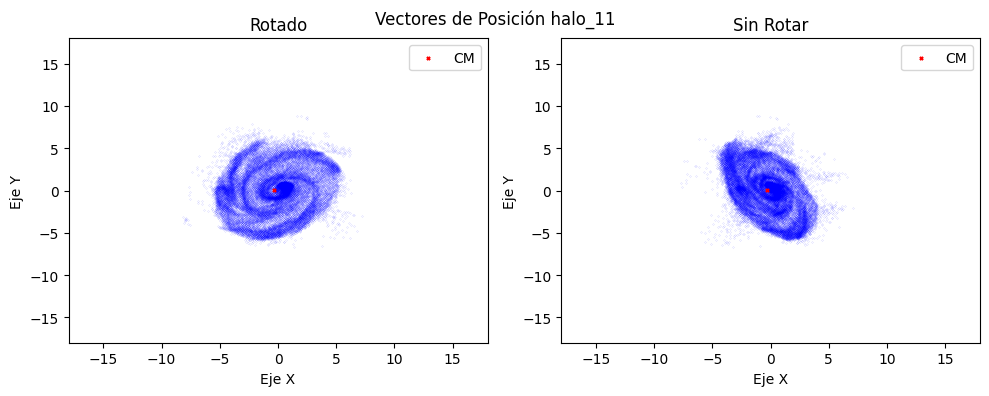

<Figure size 640x480 with 0 Axes>

In [ ]:
if __name__ == "__main__":
    simulation = GasSimulation('dhc_halo_11.gas')
    center_of_mass = simulation.calculate_center_of_mass_new()
    total_angular_momentum = simulation.calculate_total_angular_momentum()
    angular_direction = np.sign(total_angular_momentum)
    largest_component = np.argmax(np.abs(total_angular_momentum))

    print("Centro de Masa:", center_of_mass)
    print("Momento Angular Total:", total_angular_momentum)
    print("La componente más grande del momento angular es:", largest_component, '-- sign --', angular_direction[largest_component])

    simulation.visualize_rotated_vector()


    direction = angular_direction[largest_component]
    angle_rotation_matrix = simulation.choose_rotation_matrix(largest_component, direction)

    # vector a rotar, ahora es el vector posición
    original_vector = simulation.accumulated_data[:, :3]

    # Aplica la rotación al vector posición
    rotated_vectors = simulation.apply_rotation(angle_rotation_matrix, original_vector)

    # Visualizar los vectores rotados
    simulation.visualize_galaxy(original_vector, rotated_vectors, 'Vectores de Posición halo_11')

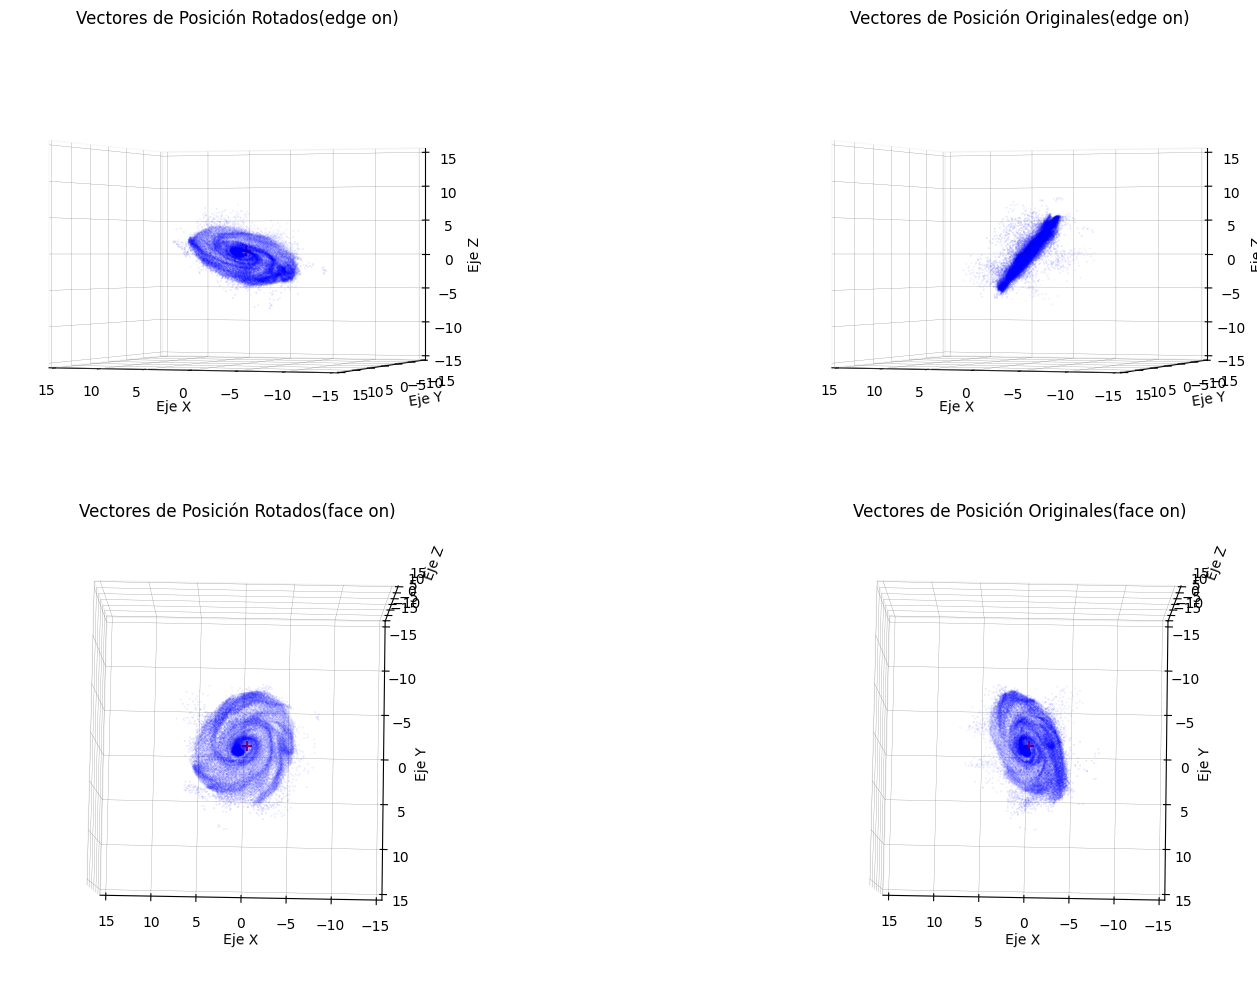

In [ ]:
simulation.visualize_3d_comparison(rotated_vectors, 'Vectores de Posición Rotados', original_vector, 'Vectores de Posición Originales')


Centro de Masa: [ 1.78124487 -0.15069158 -3.5317007 ]
Momento Angular Total: [75311410.56624626 59598549.8597213  37094310.12119162]
La componente más grande del momento angular es: 0 -- sign -- 1.0
--------------------------------------------------------------------------------
Vector Original: [75311410.56624626 59598549.8597213  37094310.12119162]
Vector Rotado: [-37094310.12119161  59598549.8597213   75311410.56624627]
--------------------------------------------------------------------------------
                                                                                


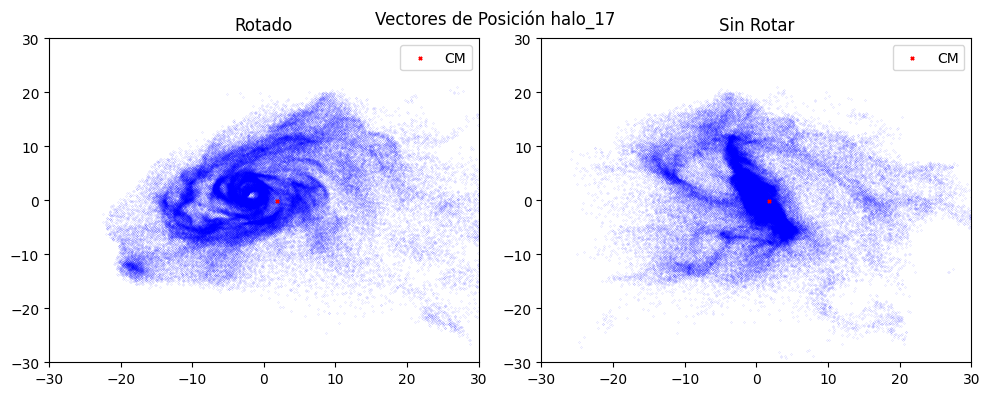

In [ ]:
if __name__ == "__main__":
    simulation = GasSimulation('dhc_halo_17.gas')
    center_of_mass = simulation.calculate_center_of_mass()
    total_angular_momentum = simulation.calculate_total_angular_momentum()
    angular_direction = np.sign(total_angular_momentum)
    largest_component = np.argmax(np.abs(total_angular_momentum))

    print("Centro de Masa:", center_of_mass)
    print("Momento Angular Total:", total_angular_momentum)
    print("La componente más grande del momento angular es:", largest_component, '-- sign --', angular_direction[largest_component])

    simulation.visualize_rotated_vector()

    direction = angular_direction[largest_component]
    angle_rotation_matrix = simulation.choose_rotation_matrix(largest_component, direction)

    # vector a rotar, ahora es el vector posición
    original_vector = simulation.accumulated_data[:, :3]

    # Aplica la rotación al vector posición
    rotated_vectors = simulation.apply_rotation(angle_rotation_matrix, original_vector)

    # Visualizar los vectores rotados
    simulation.visualize_galaxy(original_vector, rotated_vectors, 'Vectores de Posición halo_17')


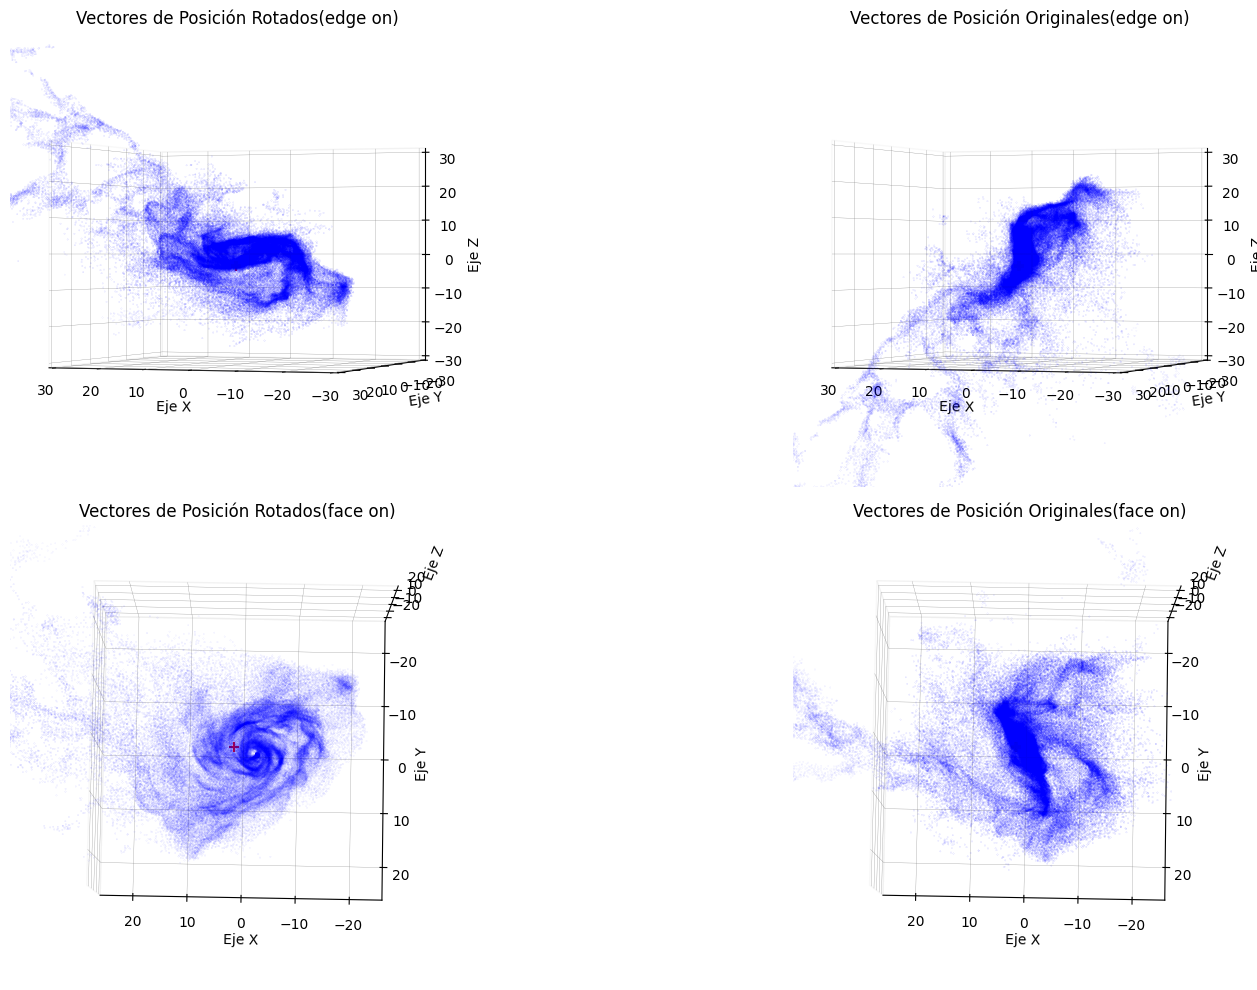

In [ ]:
simulation.visualize_3d_comparison(rotated_vectors, 'Vectores de Posición Rotados', original_vector, 'Vectores de Posición Originales')


Centro de Masa: [ 9.22054557 -7.52282565 17.15070361]
Momento Angular Total: [ 4.40719449e+08 -1.29070716e+08 -4.37834800e+08]
La componente más grande del momento angular es: 0 -- sign -- 1.0
--------------------------------------------------------------------------------
Vector Original: [ 4.40719449e+08 -1.29070716e+08 -4.37834800e+08]
Vector Rotado: [ 4.37834800e+08 -1.29070716e+08  4.40719449e+08]
--------------------------------------------------------------------------------
                                                                                


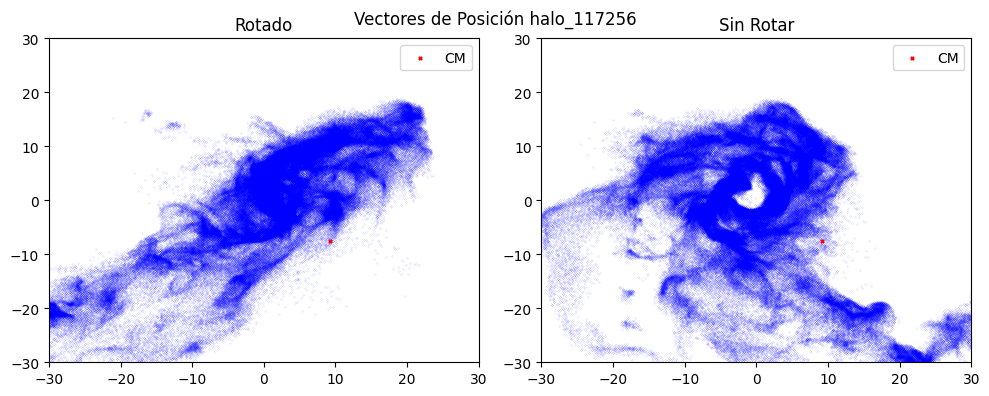

In [ ]:
if __name__ == "__main__":
    simulation = GasSimulation('halo_117256.gas')
    center_of_mass = simulation.calculate_center_of_mass()
    total_angular_momentum = simulation.calculate_total_angular_momentum()
    angular_direction = np.sign(total_angular_momentum)
    largest_component = np.argmax(np.abs(total_angular_momentum))

    print("Centro de Masa:", center_of_mass)
    print("Momento Angular Total:", total_angular_momentum)
    print("La componente más grande del momento angular es:", largest_component, '-- sign --', angular_direction[largest_component])

    simulation.visualize_rotated_vector()

    direction = angular_direction[largest_component]
    angle_rotation_matrix = simulation.choose_rotation_matrix(largest_component, direction)

    # vector a rotar, ahora es el vector posición
    original_vector = simulation.accumulated_data[:, :3]

    # Aplica la rotación al vector posición
    rotated_vectors = simulation.apply_rotation(angle_rotation_matrix, original_vector)

    # Visualizar los vectores rotados
    simulation.visualize_galaxy(original_vector, rotated_vectors, 'Vectores de Posición halo_117256')

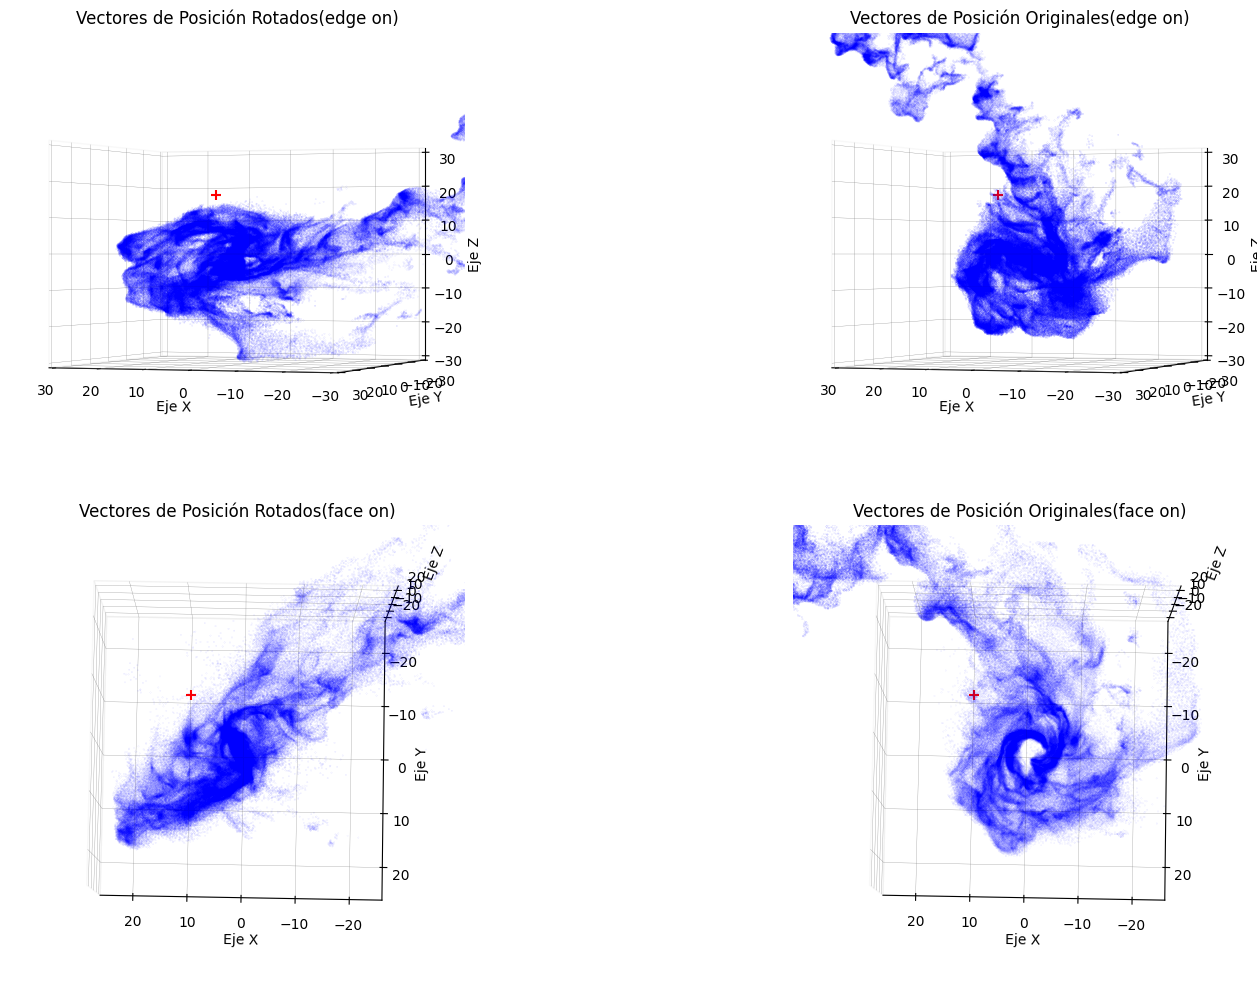

In [ ]:
simulation.visualize_3d_comparison(rotated_vectors, 'Vectores de Posición Rotados', original_vector, 'Vectores de Posición Originales')


Centro de Masa: [ 0.6861747  -0.43129766 -1.60462037]
Momento Angular Total: [-36198173.39287927   4144621.52910563    139863.01611261]
La componente más grande del momento angular es: 0 -- sign -- -1.0
--------------------------------------------------------------------------------
Vector Original: [-36198173.39287927   4144621.52910563    139863.01611261]
Vector Rotado: [  139863.0161126   4144621.52910563 36198173.39287927]
--------------------------------------------------------------------------------
                                                                                


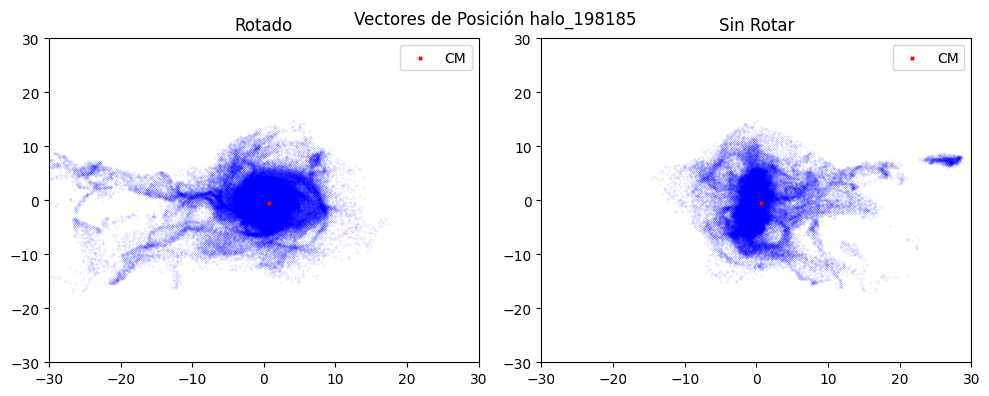

In [ ]:
if __name__ == "__main__":
    simulation = GasSimulation('halo_198185.gas')
    center_of_mass = simulation.calculate_center_of_mass()
    total_angular_momentum = simulation.calculate_total_angular_momentum()
    angular_direction = np.sign(total_angular_momentum)
    largest_component = np.argmax(np.abs(total_angular_momentum))

    print("Centro de Masa:", center_of_mass)
    print("Momento Angular Total:", total_angular_momentum)
    print("La componente más grande del momento angular es:", largest_component, '-- sign --', angular_direction[largest_component])

    simulation.visualize_rotated_vector()

    direction = angular_direction[largest_component]
    angle_rotation_matrix = simulation.choose_rotation_matrix(largest_component, direction)

    # vector a rotar, ahora es el vector posición
    original_vector = simulation.accumulated_data[:, :3]

    # Aplica la rotación al vector posición
    rotated_vectors = simulation.apply_rotation(angle_rotation_matrix, original_vector)

    # Visualizar los vectores rotados
    simulation.visualize_galaxy(original_vector, rotated_vectors, 'Vectores de Posición halo_198185')

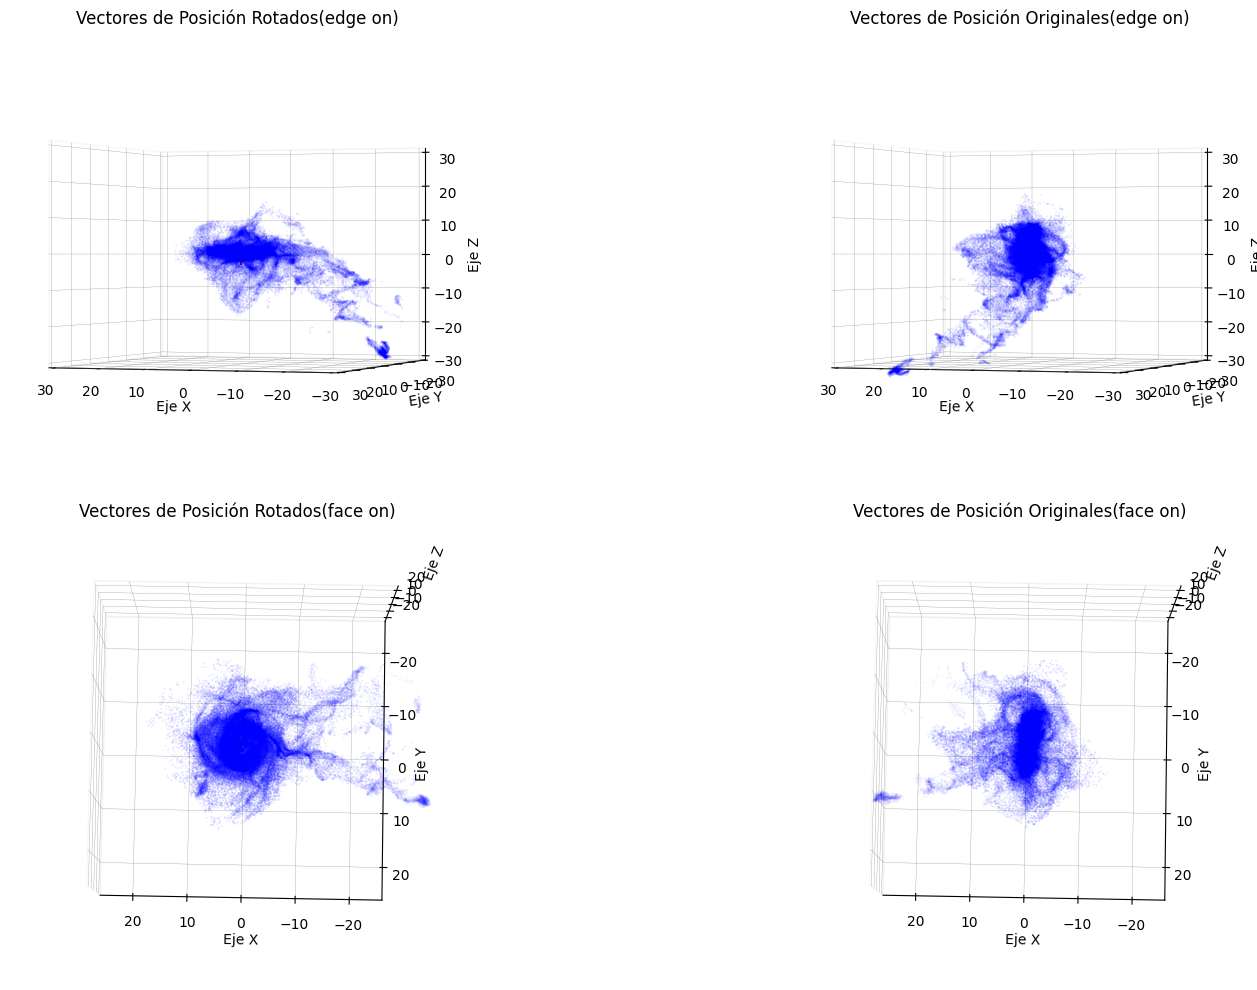

In [ ]:
simulation.visualize_3d_comparison(rotated_vectors, 'Vectores de Posición Rotados', original_vector, 'Vectores de Posición Originales')


Centro de Masa: [-0.4443283   1.8900886   1.19390738]
Momento Angular Total: [13006274.21459286 -3629950.60620877   509739.47767443]
La componente más grande del momento angular es: 0 -- sign -- 1.0
--------------------------------------------------------------------------------
Vector Original: [13006274.21459286 -3629950.60620877   509739.47767443]
Vector Rotado: [ -509739.47767443 -3629950.60620877 13006274.21459286]
--------------------------------------------------------------------------------
                                                                                


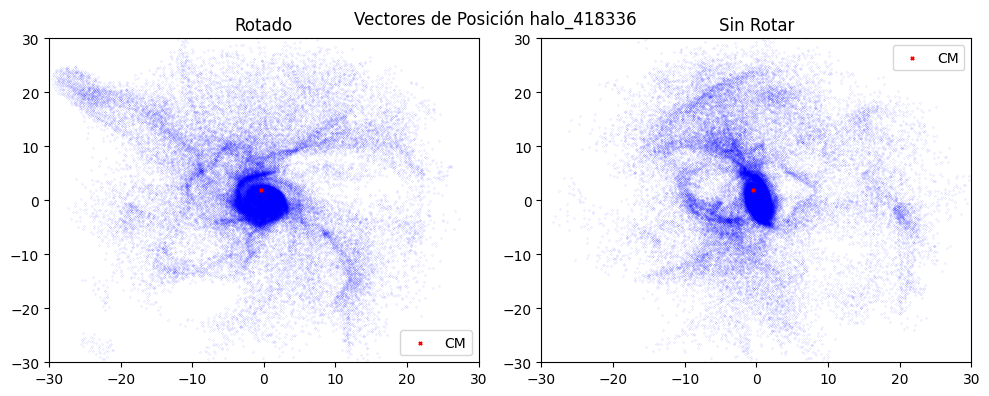

In [ ]:
if __name__ == "__main__":
    simulation = GasSimulation('halo_418336.gas')
    center_of_mass = simulation.calculate_center_of_mass()
    total_angular_momentum = simulation.calculate_total_angular_momentum()
    angular_direction = np.sign(total_angular_momentum)
    largest_component = np.argmax(np.abs(total_angular_momentum))

    print("Centro de Masa:", center_of_mass)
    print("Momento Angular Total:", total_angular_momentum)
    print("La componente más grande del momento angular es:", largest_component, '-- sign --', angular_direction[largest_component])

    simulation.visualize_rotated_vector()

    direction = angular_direction[largest_component]
    angle_rotation_matrix = simulation.choose_rotation_matrix(largest_component, direction)

    # vector a rotar, ahora es el vector posición
    original_vector = simulation.accumulated_data[:, :3]

    # Aplica la rotación al vector posición
    rotated_vectors = simulation.apply_rotation(angle_rotation_matrix, original_vector)

    # Visualizar los vectores rotados
    simulation.visualize_galaxy(original_vector, rotated_vectors, 'Vectores de Posición halo_418336')

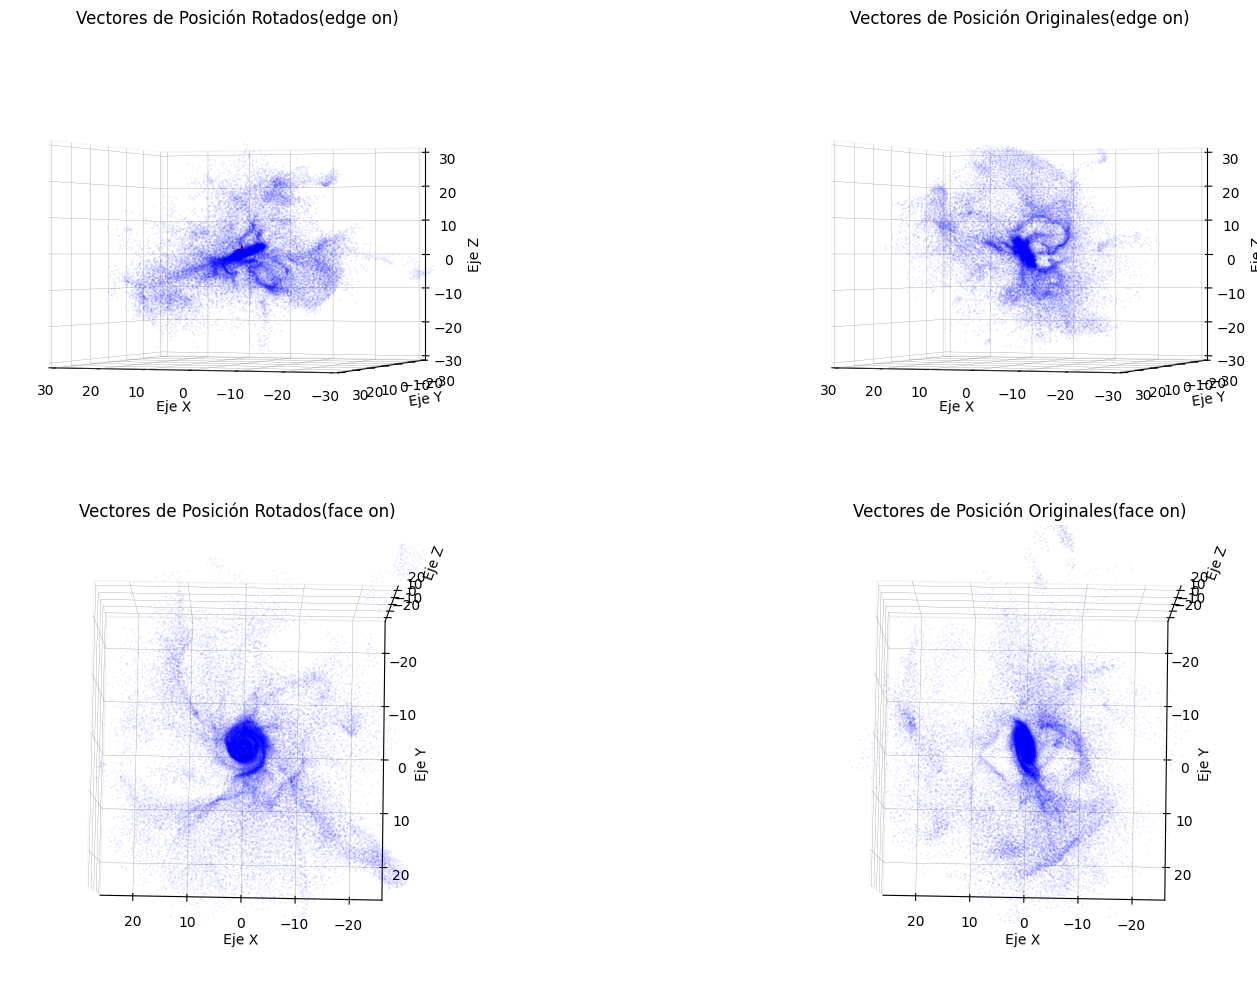

In [ ]:
simulation.visualize_3d_comparison(rotated_vectors, 'Vectores de Posición Rotados', original_vector, 'Vectores de Posición Originales')
